Dataset: LIVECell (microscopy, instance segmentation)
Model: SAM ViT-B
Training scope:

Image encoder: frozen

Prompt encoder: frozen

Mask decoder: trainable

This mirrors how LLMs are adapted in production.

In [2]:
#%pip install opencv-python
#%pip install pycocotools
# This magic install is the last resort due to mixmatch of venv in bash and notebook kernel, no choice
# this issue is fixed by force install into the absolute path
# use bash not cmd, not ps, just bash

In [14]:
"""
{
    "info": {
        "description": "COCO 2017 Dataset","url": "http://cocodataset.org","version": "1.0","year": 2017,"contributor": "COCO Consortium","date_created": "2017/09/01"
    },
    "licenses": [
        {"url": "http://creativecommons.org/licenses/by/2.0/","id": 4,"name": "Attribution License"}
    ],
    "images": [
        {"id": 242287, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/xxxxxxxxxxxx.jpg", "flickr_url": "http://farm3.staticflickr.com/2626/xxxxxxxxxxxx.jpg", "width": 426, "height": 640, "file_name": "xxxxxxxxx.jpg", "date_captured": "2013-11-15 02:41:42"},
        {"id": 245915, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/nnnnnnnnnnnn.jpg", "flickr_url": "http://farm1.staticflickr.com/88/xxxxxxxxxxxx.jpg", "width": 640, "height": 480, "file_name": "nnnnnnnnnn.jpg", "date_captured": "2013-11-18 02:53:27"}
    ],
    "annotations": [
        {"id": 125686, "category_id": 0, "iscrowd": 0, "segmentation": [[164.81, 417.51,......167.55, 410.64]], "image_id": 242287, "area": 42061.80340000001, "bbox": [19.23, 383.18, 314.5, 244.46]},
        {"id": 1409619, "category_id": 0, "iscrowd": 0, "segmentation": [[376.81, 238.8,........382.74, 241.17]], "image_id": 245915, "area": 3556.2197000000015, "bbox": [399, 251, 155, 101]},
        {"id": 1410165, "category_id": 1, "iscrowd": 0, "segmentation": [[486.34, 239.01,..........495.95, 244.39]], "image_id": 245915, "area": 1775.8932499999994, "bbox": [86, 65, 220, 334]}
    ],
    "categories": [
        {"supercategory": "speaker","id": 0,"name": "echo"},
        {"supercategory": "speaker","id": 1,"name": "echo dot"}
    ]
}
"""

'\n{\n    "info": {\n        "description": "COCO 2017 Dataset","url": "http://cocodataset.org","version": "1.0","year": 2017,"contributor": "COCO Consortium","date_created": "2017/09/01"\n    },\n    "licenses": [\n        {"url": "http://creativecommons.org/licenses/by/2.0/","id": 4,"name": "Attribution License"}\n    ],\n    "images": [\n        {"id": 242287, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/xxxxxxxxxxxx.jpg", "flickr_url": "http://farm3.staticflickr.com/2626/xxxxxxxxxxxx.jpg", "width": 426, "height": 640, "file_name": "xxxxxxxxx.jpg", "date_captured": "2013-11-15 02:41:42"},\n        {"id": 245915, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/nnnnnnnnnnnn.jpg", "flickr_url": "http://farm1.staticflickr.com/88/xxxxxxxxxxxx.jpg", "width": 640, "height": 480, "file_name": "nnnnnnnnnn.jpg", "date_captured": "2013-11-18 02:53:27"}\n    ],\n    "annotations": [\n        {"id": 125686, "category_id": 0, "iscrowd": 0, "segmentation": [[16

In [47]:
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from torchvision.transforms.functional import to_tensor


class LIVECellDataset(Dataset):
    def __init__(self, image_dir, ann_file, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

        # category id → name
        self.cat_id_to_name = {
            cat_id: cat["name"]
            for cat_id, cat in self.coco.cats.items()
        }

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]

        # Load image
        img_path = f"{self.image_dir}/{img_info['file_name']}"
        image = Image.open(
        f"{self.image_dir}/{img_info['file_name']}").convert("RGB")

        image = to_tensor(image)   # ← THIS LINE IS NON-NEGOTIABLE

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []

        for ann in anns:
            # Mask
            rle = self.coco.annToRLE(ann)
            mask = coco_mask.decode(rle)
            masks.append(mask)

            # Bounding box (COCO: x,y,w,h → x1,y1,x2,y2)
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])

            # Category
            labels.append(ann["category_id"])

        sample = {
            "image": image,
            "masks": np.stack(masks) if masks else np.zeros((0,)),
            "boxes": np.array(boxes, dtype=np.float32),
            "labels": labels,
            "image_id": image_id,
        }

        if self.transforms:
            sample = self.transforms(sample)

        return sample



In [48]:
# instantiate the dataset
dataset = LIVECellDataset(
    image_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json"
)

sample = dataset[42]

loading annotations into memory...
Done (t=5.67s)
creating index...
index created!


In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(sample, cat_id_to_name):
    image = sample["image"]
    masks = sample["masks"]
    boxes = sample["boxes"]
    labels = sample["labels"]

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(image)

    # Masks
    for mask in masks:
        ax.imshow(
            np.ma.masked_where(mask == 0, mask),
            alpha=0.4
        )

    # Boxes + labels
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            y1 - 5,
            cat_id_to_name[label],
            color="red",
            fontsize=10,
            backgroundcolor="white"
        )

    ax.set_title(f"Image ID: {sample['image_id']}")
    ax.axis("off")
    plt.show()



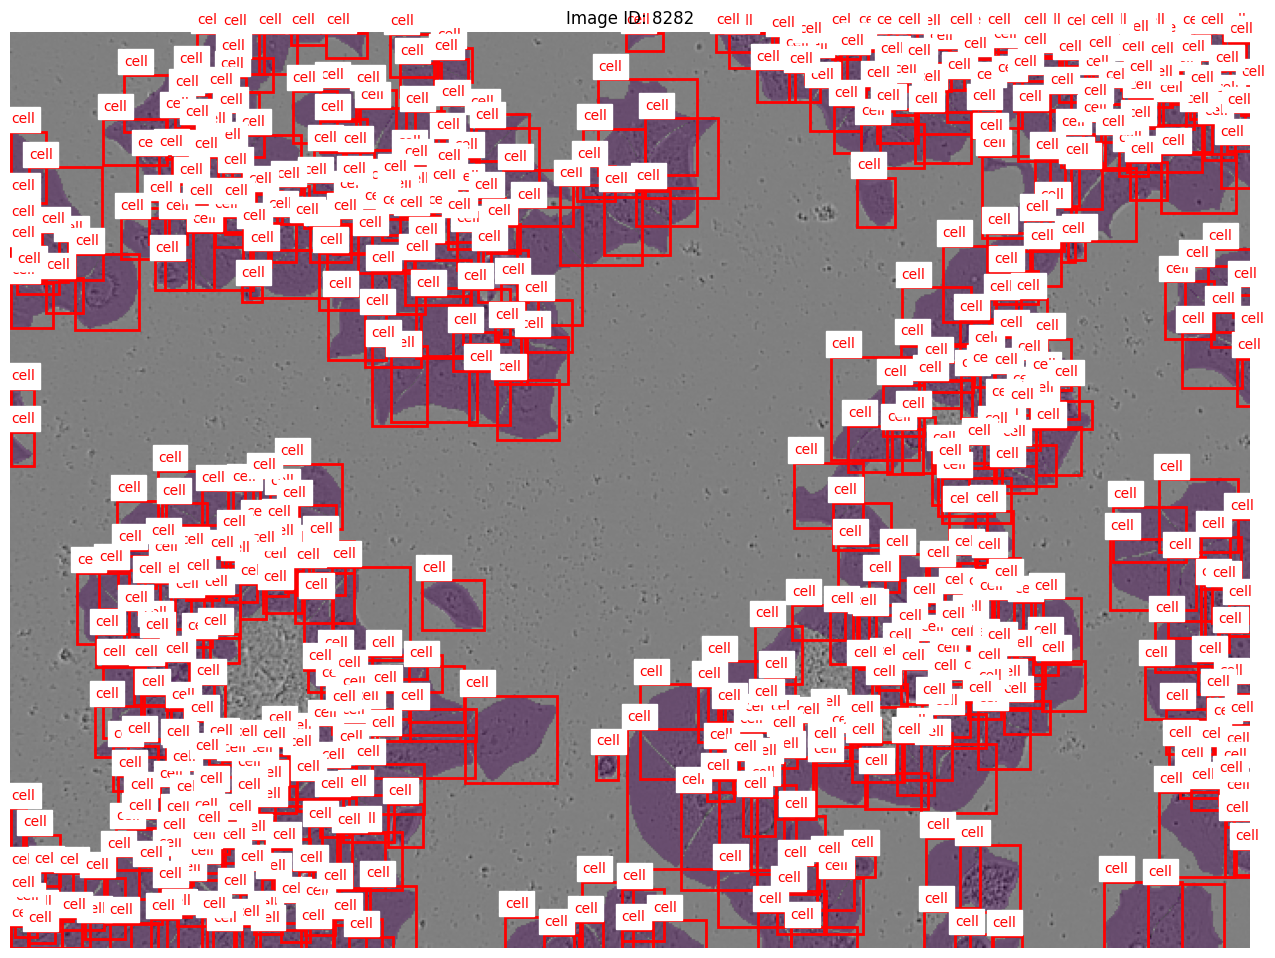

In [40]:
visualize_sample(dataset[42], dataset.cat_id_to_name)

In [11]:
# let's check dimension of tensors
def inspect_tensor(name, x):
    if x is None:
        print(f"{name}: None")
        return

    if isinstance(x, (list, tuple)):
        print(f"{name}: {type(x)} len={len(x)}")
        for i, xi in enumerate(x):
            inspect_tensor(f"{name}[{i}]", xi)
        return

    print(
        f"{name}: "
        f"shape={tuple(x.shape)}, "
        f"dtype={x.dtype}, "
    )


In [65]:
# ---- RAW DATA ----
device = "cuda"
image_inspect = dataset[42]["image"]
masks_inspect = dataset[42]["masks"]
#prompt_inspect = sample_point_from_mask(masks_inspect)


inspect_tensor("img", image_inspect)           # expected: [B, 3, H, W], float32, cuda
inspect_tensor("mask", masks_inspect)         # expected: [B, H, W] or [B, 1, H, W], bool/float
#inspect_tensor("point", prompt_inspect)       # expected: [B, 1, 2], long/int/float

img: shape=(3, 520, 704), dtype=torch.float32, 
mask: shape=(540, 520, 704), dtype=uint8, 


In [67]:
#thinking at model–data contract level, and you can only discover this by practice. I did not realize this beforehand

#LIVECell provides instance segmentation
#Each slice mask[i] is a binary mask for one cell
#This is not a semantic mask

# SAM’s prompt model expects one target per prompt, not 540

In [49]:
import torch
import torch.nn.functional as F

def dice_loss(pred, target, eps=1e-6):
    num = 2 * (pred * target).sum()
    den = pred.sum() + target.sum() + eps
    return 1 - num / den

def seg_loss(pred, target):
    pred = torch.sigmoid(pred)
    return dice_loss(pred, target) + F.binary_cross_entropy(pred, target)


This is a very good moment to pause and realign interfaces. What you have now is a mismatch between three layers: \

Your dataset (returns a dict with image / masks / boxes / labels)\

Your DataLoader (default collate)\

Your training loop (expects (img, mask, point) tuples)\

Nothing here is conceptually wrong, but they are not speaking the same contract.

In [43]:
"""
Dataset → image + GT masks
Training loop → sample box / point prompts
SAM → predict mask
Loss → GT mask

"""

'\nDataset → image + GT masks\nTraining loop → sample box / point prompts\nSAM → predict mask\nLoss → GT mask\n\n'

In [73]:
# thinkg about another embedding dimension issue:

#Your image token grid is 44 × something
#SAM’s positional encoding grid is hard-coded to 64 × 64

# the following image embedding and position embedding addition does not work
#image_tokens: [B, 256, 44, 64]   (example)
#pos_embed:    [1, 256, 64, 64]

# root cause is the SAM requests a fix image size 1024 x 1024
# 64 = 1024 /16
# but the image I have is 520 x 704
#704 / 16 ≈ 44

In [60]:
# The LIVECELL COCO JSON file contains images and annotations (segmentation polygons and bounding boxes). You don't see "prompts" because prompts are generated on-the-fly during training using the ground truth data.
# It "simulates" a prompt: it randomly picks a point inside the ground-truth mask to use as a "Point Prompt."

def sample_point_from_mask(mask):
    """
    mask: Tensor[H, W] or [1, H, W]
    returns: Tensor[1, 2] (x, y)
    """
    if mask.ndim == 3:
        mask = mask.squeeze(0)

    ys, xs = torch.where(mask > 0)
    idx = torch.randint(0, len(xs), (1,))
    return torch.stack([xs[idx], ys[idx]], dim=-1)


In [ ]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam.to(device)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

# dataset = LiveCellDataset(
#     img_dir="data/livecell/images/train",
#     ann_file="data/livecell/annotations/train.json"
# )

loader = DataLoader(
    dataset,
    batch_size=1,   # IMPORTANT: start with 1 for SAM
    shuffle=True
)

sam.train()

for epoch in range(10):
    pbar = tqdm(loader)

    for batch in pbar:
        image = batch["image"].to(device)          # [1, 3, H, W]
        gt_masks = batch["masks"].to(device)   # [1, N, H, W]
        gt_mask = gt_masks[0][0] # pick ONE instance per image (simplest valid setup); just for now
        # instance_idx = torch.randint(0, gt_masks.shape[0], (1,)).item()
        # gt_mask = gt_masks[instance_idx]

        point = sample_point_from_mask(gt_mask)    # [1, 2]
        point = point.to(device)

        with torch.no_grad():
            image_embedding = sam.image_encoder(image)

        sparse, dense = sam.prompt_encoder(
            points=(point, torch.ones((1, 1), device=device)),
            boxes=None,
            masks=None
        )

        low_res_masks, _ = sam.mask_decoder(
            image_embedding,
            sam.prompt_encoder.get_dense_pe(),
            sparse,
            dense,
            multimask_output=False
        )

        # Resize GT mask to low-res SAM output
        gt_mask = gt_mask.unsqueeze(0).unsqueeze(0).float()
        
        gt_mask = torch.nn.functional.interpolate(
            gt_mask,
            size=low_res_masks.shape[-2:],
            mode="nearest"
        )

        loss = seg_loss(low_res_masks, gt_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"epoch {epoch} | loss {loss.item():.4f}")
        break



  0%|          | 0/3253 [00:00<?, ?it/s]

torch.Size([520, 704])


RuntimeError: The size of tensor a (44) must match the size of tensor b (64) at non-singleton dimension 2

The embedding dimension is a major fix and here the startover copy

In [74]:
import json
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide


class LiveCellSAMDataset(Dataset):
    def __init__(self, img_dir, ann_file, sam_model):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())

        # SAM transform (fixed contract)
        self.transform = ResizeLongestSide(1024)

        # required for normalization
        self.pixel_mean = sam_model.pixel_mean
        self.pixel_std = sam_model.pixel_std

    def __len__(self):
        return len(self.image_ids)

    def _sample_point(self, mask):
        ys, xs = torch.where(mask > 0)
        idx = torch.randint(0, len(xs), (1,))
        return torch.stack([xs[idx], ys[idx]], dim=-1)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.imgs[image_id]

        # ---- load image ----
        image = Image.open(f"{self.img_dir}/{img_info['file_name']}").convert("RGB")
        image = np.array(image)

        H, W = image.shape[:2]

        # ---- load instance masks ----
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        for ann in anns:
            masks.append(self.coco.annToMask(ann))

        masks = torch.from_numpy(np.stack(masks)).to(torch.uint8)  # [N,H,W]

        # ---- pick ONE instance ----
        inst_idx = torch.randint(0, masks.shape[0], (1,)).item()
        gt_mask = masks[inst_idx]                                   # [H,W]

        # ---- sample prompt ----
        point = self._sample_point(gt_mask)                         # [1,2]

        # ---- apply SAM transforms ----
        image = self.transform.apply_image(image)
        gt_mask = self.transform.apply_image(gt_mask.numpy())
        point = self.transform.apply_coords(point.numpy(), (H, W))

        # ---- tensorize & normalize ----
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        image = (image - self.pixel_mean) / self.pixel_std

        gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        point = torch.from_numpy(point).float()

        return {
            "image": image,
            "mask": gt_mask,
            "point": point,
            "image_id": image_id,
        }


In [ ]:
dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)


loading annotations into memory...
Done (t=6.93s)
creating index...
index created!


In [85]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]
    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():
        image_embedding = sam.image_encoder(img)

    sparse, dense = sam.prompt_encoder(
        points=(point, torch.ones(point.shape[:2], device=device)),
        boxes=None,
        masks=None
    )

    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        sam.prompt_encoder.get_dense_pe(),
        sparse,
        dense,
        multimask_output=False
    )
    break


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [86]:
# OK, all problem is from this line of code
# first of a hard design rule of PyTorch: Datasets must be device-agnostic and CPU-only.
# But LiveCellSAMDataset(..., sam_model=sam) model is being passe inside the dataset
#self.pixel_mean = sam_model.pixel_mean
#self.pixel_std = sam_model.pixel_std
#sam.to(device)

#image = (image - self.pixel_mean) / self.pixel_std

# your image is inside CPU, Because pixel_mean and pixel_std are references, they moved to CUDA, but the Dataset kept pointing to them.

# Summary on Dataset, Stay on CPU

In [ ]:
# for batch in loader:
#     img = batch["image"].to(device)        # [B,3,1024,1024]
#     gt_mask = batch["mask"].to(device)
#     point = batch["point"].to(device)

#     # normalize HERE, on GPU
#     img = (img - sam.pixel_mean) / sam.pixel_std

In [7]:
import json
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide


class LiveCellSAMDataset(Dataset):
    def __init__(self, img_dir, ann_file, sam_model):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())

        # SAM transform (fixed contract)
        self.transform = ResizeLongestSide(1024)

        # required for normalization
        self.pixel_mean = sam_model.pixel_mean
        self.pixel_std = sam_model.pixel_std

    def __len__(self):
        return len(self.image_ids)

    def _sample_point(self, mask):
        ys, xs = torch.where(mask > 0)
        idx = torch.randint(0, len(xs), (1,))
        return torch.stack([xs[idx], ys[idx]], dim=-1)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.imgs[image_id]

        # ---- load image ----
        image = Image.open(f"{self.img_dir}/{img_info['file_name']}").convert("RGB")
        image = np.array(image)

        H, W = image.shape[:2]

        # ---- load instance masks ----
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        for ann in anns:
            masks.append(self.coco.annToMask(ann))

        masks = torch.from_numpy(np.stack(masks)).to(torch.uint8)  # [N,H,W]

        # ---- pick ONE instance ----
        inst_idx = torch.randint(0, masks.shape[0], (1,)).item()
        gt_mask = masks[inst_idx]                                   # [H,W]

        # ---- sample prompt ----
        point = self._sample_point(gt_mask)                         # [1,2]

        # ---- apply SAM transforms ----
        image = self.transform.apply_image(image)
        gt_mask = self.transform.apply_image(gt_mask.numpy())
        point = self.transform.apply_coords(point.numpy(), (H, W))

        # ---- tensorize & normalize ----
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        image = image / 255.0

        gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        point = torch.from_numpy(point).float()

        return {
            "image": image,
            "mask": gt_mask,
            "point": point,
            "image_id": image_id,
        }

In [90]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]
    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():
        image_embedding = sam.image_encoder(img)

    sparse, dense = sam.prompt_encoder(
        points=(point, torch.ones(point.shape[:2], device=device)),
        boxes=None,
        masks=None
    )

    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        sam.prompt_encoder.get_dense_pe(),
        sparse,
        dense,
        multimask_output=False
    )
    break


RuntimeError: The size of tensor a (47) must match the size of tensor b (64) at non-singleton dimension 1

In [91]:
"""
Key facts:

SAM ViT-B expects exactly 64×64 = 4096 tokens

Your image produced 47×64 tokens (or similar)

Positional embedding is fixed at 64×64

SAM does NOT interpolate positional embeddings

So even though you resized the longest side to 1024, your image is still not square.

Example:

Original: 520 × 704

After ResizeLongestSide(1024) → 755 × 1024

Tokens: 755/16 ≈ 47, 1024/16 = 64

That 47 is the error.

"""

'\nKey facts:\n\nSAM ViT-B expects exactly 64×64 = 4096 tokens\n\nYour image produced 47×64 tokens (or similar)\n\nPositional embedding is fixed at 64×64\n\nSAM does NOT interpolate positional embeddings\n\nSo even though you resized the longest side to 1024, your image is still not square.\n\nExample:\n\nOriginal: 520 × 704\n\nAfter ResizeLongestSide(1024) → 755 × 1024\n\nTokens: 755/16 ≈ 47, 1024/16 = 64\n\nThat 47 is the error.\n\n'

In [19]:
# ---- RAW DATA ----
device = "cuda"
image_inspect = dataset[42]["image"]
masks_inspect = dataset[42]["mask"]
#prompt_inspect = sample_point_from_mask(masks_inspect)


inspect_tensor("image", image_inspect)           # expected: [B, 3, H, W], float32, cuda
inspect_tensor("mask", masks_inspect)         # expected: [B, H, W] or [B, 1, H, W], bool/float
#inspect_tensor("point", prompt_inspect)       # expected: [B, 1, 2], long/int/float

image: shape=(3, 756, 1024), dtype=torch.float32, 
mask: shape=(1, 756, 1024), dtype=torch.float32, 


In [20]:
# Pad the shorter side to 1024
def sam_preprocess_image(image, sam, device):
    """
    image: Tensor [3, H, W] in [0,1], CPU
    returns: Tensor [1,3,1024,1024] on device
    """

    # pad to square
    pad_h = 1024 - 756
    pad_w = 1024 - 1024

    image = torch.nn.functional.pad(
        image,
        (0, pad_w, 0, pad_h),  # (left, right, top, bottom)
        value=0.0
    )

    # image = image.unsqueeze(0).to(device)
    # image = (image - sam.pixel_mean) / sam.pixel_std
    return image


In [21]:
image_inspect_processed = sam_preprocess_image(image_inspect, sam, device)
inspect_tensor("image", image_inspect_processed)  

image: shape=(3, 1024, 1024), dtype=torch.float32, 


In [22]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]

    pad_h = 1024 - 1024
    pad_w = 1024 - 755
    gt_mask = torch.nn.functional.pad(
    gt_mask,
    (0, pad_w, 0, pad_h),
    value=0
    )

    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():

        img = sam_preprocess_image(img, sam, device)

        image_embedding = sam.image_encoder(img)

    sparse, dense = sam.prompt_encoder(
        points=(point, torch.ones(point.shape[:2], device=device)),
        boxes=None,
        masks=None
    )

    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        sam.prompt_encoder.get_dense_pe(),
        sparse,
        dense,
        multimask_output=False
    )
    break

loading annotations into memory...
Done (t=5.46s)
creating index...
index created!
cuda:0 cuda:0 cuda:0 cuda:0


RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [ ]:
"""
For mask_decoder, SAM assumes:

image_embedding:        [B, C, H, W]
dense_prompt_embeddings: [B, C, H, W]
sparse_prompt_embeddings: [B, N, C]

SAM treats each prompt independently.
effective_batch = B × P

"""

'\nFor mask_decoder, SAM assumes:\n\nimage_embedding:        [B, C, H, W]\ndense_prompt_embeddings: [B, C, H, W]\nsparse_prompt_embeddings: [B, N, C]\n\n'

In [28]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]

    pad_h = 1024 - 1024
    pad_w = 1024 - 755
    gt_mask = torch.nn.functional.pad(
    gt_mask,
    (0, pad_w, 0, pad_h),
    value=0
    )

    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():

        img = sam_preprocess_image(img, sam, device)

        image_embedding = sam.image_encoder(img)

    assert point.ndim == 3
    assert point.shape[1] == 1
    # keep only the first point per image
    print("point.shape:", point.shape)
    print(point)
    point = point[:, 0:1, :]           # [B,1,2]

    # create corresponding labels
    labels = torch.ones((point.shape[0], 1), device=device, dtype=torch.int64)

    sparse, dense = sam.prompt_encoder(
        points=(point, labels),
        boxes=None,
        masks=None
    )

    print(sparse.shape)  # should now be [B,1,256]


    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    print(
    image_embedding.shape,
    dense.shape,
    sparse.shape
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        sam.prompt_encoder.get_dense_pe(),
        sparse,
        dense,
        multimask_output=False
    )
    break

loading annotations into memory...
Done (t=5.42s)
creating index...
index created!
point.shape: torch.Size([4, 1, 2])
tensor([[[651.6364, 261.6923]],

        [[587.6364,  72.6923]],

        [[424.7273, 708.0231]],

        [[650.1818, 274.7769]]], device='cuda:0')
torch.Size([4, 2, 256])
cuda:0 cuda:0 cuda:0 cuda:0
torch.Size([4, 256, 64, 64]) torch.Size([4, 256, 64, 64]) torch.Size([4, 2, 256])


RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [30]:
"""
Why sparse has 2 in the middle dimension

You passed 1 point per image: [B,1,2]

labels = [B,1]

But your SAM ViT-B model is a ViT-H decoder variant or fine-tuned checkpoint. Some versions of SAM have 2 “sparse embeddings per point” hardcoded:

So even with 1 point per image, sparse shape = [B, 2, 256]. This is actually expected behavior in SAM.

✅ In other words, your input is correct; this does not need to be sliced further.

"""

'\nWhy sparse has 2 in the middle dimension\n\nYou passed 1 point per image: [B,1,2]\n\nlabels = [B,1]\n\nBut your SAM ViT-B model is a ViT-H decoder variant or fine-tuned checkpoint. Some versions of SAM have 2 “sparse embeddings per point” hardcoded:\n\nSo even with 1 point per image, sparse shape = [B, 2, 256]. This is actually expected behavior in SAM.\n\n✅ In other words, your input is correct; this does not need to be sliced further.\n\n'

In [31]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]

    pad_h = 1024 - 1024
    pad_w = 1024 - 755
    gt_mask = torch.nn.functional.pad(
    gt_mask,
    (0, pad_w, 0, pad_h),
    value=0
    )

    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():

        img = sam_preprocess_image(img, sam, device)

        image_embedding = sam.image_encoder(img)

    assert point.ndim == 3
    assert point.shape[1] == 1
    # keep only the first point per image
    print("point.shape:", point.shape)
    print(point)
    point = point[:, 0:1, :]           # [B,1,2]

    # create corresponding labels
    labels = torch.ones((point.shape[0], 1), device=device, dtype=torch.int64)

    sparse, dense = sam.prompt_encoder(
        points=(point, labels),
        boxes=None,
        masks=None
    )

    print(sparse.shape)  # should now be [B,1,256]


    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    print(
    image_embedding.shape,
    dense.shape,
    sparse.shape
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding=image_embedding,
        image_pe=sam.prompt_encoder.get_dense_pe().to(device),
        sparse_prompt_embeddings=sparse,
        dense_prompt_embeddings=dense,
        multimask_output=False
    )
    
    break

loading annotations into memory...
Done (t=6.98s)
creating index...
index created!
point.shape: torch.Size([4, 1, 2])
tensor([[[833.4545, 671.6769]],

        [[970.1818, 162.8308]],

        [[375.2727, 578.6308]],

        [[862.5455, 388.1769]]], device='cuda:0')
torch.Size([4, 2, 256])
cuda:0 cuda:0 cuda:0 cuda:0
torch.Size([4, 256, 64, 64]) torch.Size([4, 256, 64, 64]) torch.Size([4, 2, 256])


TypeError: MaskDecoder.forward() got an unexpected keyword argument 'image_embedding'

In [32]:
"""
You’re calling sam.mask_decoder(...) with named arguments that the MaskDecoder.forward does not accept.

In the official SAM repository, MaskDecoder.forward expects positional arguments, not image_embedding=image_embedding etc.

MaskDecoder.forward(
    image_embeddings,   # positional, tensor [B, C, H, W]
    image_pe,           # positional, tensor [B, C, H, W]
    sparse_prompt_embeddings,
    dense_prompt_embeddings,
    multimask_output=False
)

"""

'\nYou’re calling sam.mask_decoder(...) with named arguments that the MaskDecoder.forward does not accept.\n\nIn the official SAM repository, MaskDecoder.forward expects positional arguments, not image_embedding=image_embedding etc.\n\nMaskDecoder.forward(\n    image_embeddings,   # positional, tensor [B, C, H, W]\n    image_pe,           # positional, tensor [B, C, H, W]\n    sparse_prompt_embeddings,\n    dense_prompt_embeddings,\n    multimask_output=False\n)\n\n'

In [34]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]

    pad_h = 1024 - 1024
    pad_w = 1024 - 755
    gt_mask = torch.nn.functional.pad(
    gt_mask,
    (0, pad_w, 0, pad_h),
    value=0
    )

    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():

        img = sam_preprocess_image(img, sam, device)

        image_embedding = sam.image_encoder(img)

    assert point.ndim == 3
    assert point.shape[1] == 1
    # keep only the first point per image
    print("point.shape:", point.shape)
    print(point)
    point = point[:, 0:1, :]           # [B,1,2]

    # create corresponding labels
    labels = torch.ones((point.shape[0], 1), device=device, dtype=torch.int64)

    sparse, dense = sam.prompt_encoder(
        points=(point, labels),
        boxes=None,
        masks=None
    )

    print(sparse.shape)  # should now be [B,1,256]


    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    print(
    image_embedding.shape,
    dense.shape,
    sparse.shape
    )

    # image_embedding: [B, C, H, W]
    # dense: dense prompt embeddings
    # sparse: sparse prompt embeddings
    # device = cuda


    
    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        image_pe=sam.prompt_encoder.get_dense_pe().to(device),
        sparse_prompt_embeddings=sparse,
        dense_prompt_embeddings=dense,
        multimask_output=False
    )
    
    
    break

loading annotations into memory...
Done (t=5.56s)
creating index...
index created!
point.shape: torch.Size([4, 1, 2])
tensor([[[768.0000,  52.3385]],

        [[923.6364, 462.3231]],

        [[821.8182, 485.5846]],

        [[960.0000, 660.0461]]], device='cuda:0')
torch.Size([4, 2, 256])
cuda:0 cuda:0 cuda:0 cuda:0
torch.Size([4, 256, 64, 64]) torch.Size([4, 256, 64, 64]) torch.Size([4, 2, 256])


RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [35]:
"""
Even though your point tensor is [4, 1, 2], the mask decoder still thinks you have 2 prompts per image (sparse.shape = [4, 2, 256]). That internal 2 comes from the “default two embeddings per point” that SAM generates internally — 
it multiplies the batch when combining with dense_prompt_embeddings.

image_embedding: [4, 256, 64, 64]
dense_prompt_embeddings: [4, 256, 64, 64]
sparse: [4, 2, 256]  # 2 internal embeddings

SAM tries to flatten the sparse prompts across the batch (B*N = 8) but dense_prompt_embeddings is still [4, 256, 64, 64].

➡️ Result: RuntimeError: size mismatch (16 vs 4).

"""

'\nEven though your point tensor is [4, 1, 2], the mask decoder still thinks you have 2 prompts per image (sparse.shape = [4, 2, 256]). That internal 2 comes from the “default two embeddings per point” that SAM generates internally — \nit multiplies the batch when combining with dense_prompt_embeddings.\n\nimage_embedding: [4, 256, 64, 64]\ndense_prompt_embeddings: [4, 256, 64, 64]\nsparse: [4, 2, 256]  # 2 internal embeddings\n\nSAM tries to flatten the sparse prompts across the batch (B*N = 8) but dense_prompt_embeddings is still [4, 256, 64, 64].\n\n➡️ Result: RuntimeError: size mismatch (16 vs 4).\n\n'

In [36]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
# from dataset import LiveCellDataset
# from losses import seg_loss
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)
sam.train()

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-4
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


for batch in loader:
    img = batch["image"].to(device)       # [B,3,1024,1024]
    
    gt_mask = batch["mask"].to(device)    # [B,1,1024,1024]

    pad_h = 1024 - 1024
    pad_w = 1024 - 755
    gt_mask = torch.nn.functional.pad(
    gt_mask,
    (0, pad_w, 0, pad_h),
    value=0
    )

    point = batch["point"].to(device)     # [B,1,2]

    img = (img - sam.pixel_mean) / sam.pixel_std
    
    with torch.no_grad():

        img = sam_preprocess_image(img, sam, device)

        image_embedding = sam.image_encoder(img)

    assert point.ndim == 3
    assert point.shape[1] == 1
    # keep only the first point per image
    print("point.shape:", point.shape)
    print(point)
    point = point[:, 0:1, :]           # [B,1,2]

    # create corresponding labels
    labels = torch.ones((point.shape[0], 1), device=device, dtype=torch.int64)

    sparse, dense = sam.prompt_encoder(
        points=(point, labels),
        boxes=None,
        masks=None
    )

    print(sparse.shape)  # should now be [B,1,256]


    print(
    image_embedding.device,
    sparse.device,
    dense.device,
    sam.prompt_encoder.get_dense_pe().device
    )

    print(
    image_embedding.shape,
    dense.shape,
    sparse.shape
    )

    # image_embedding: [B, C, H, W]
    # dense: dense prompt embeddings
    # sparse: sparse prompt embeddings
    # device = cuda

    B, C, H, W = image_embedding.shape
    N = sparse.shape[1]  # number of internal sparse embeddings (usually 2)

    dense_pe = sam.prompt_encoder.get_dense_pe().to(device)
    dense_pe_expanded = dense_pe.repeat_interleave(N, dim=0)
        
    low_res_masks, _ = sam.mask_decoder(
        image_embedding.repeat_interleave(N, dim=0),  # repeat image embeddings
        image_pe=dense_pe_expanded,
        sparse_prompt_embeddings=sparse.view(B*N, -1, 256),  # flatten
        dense_prompt_embeddings=dense,
        multimask_output=False
    )
    
    break

loading annotations into memory...
Done (t=5.84s)
creating index...
index created!
point.shape: torch.Size([4, 1, 2])
tensor([[[670.5455,  56.7000]],

        [[520.7273, 335.8385]],

        [[852.3636, 312.5769]],

        [[254.5455, 472.5000]]], device='cuda:0')
torch.Size([4, 2, 256])
cuda:0 cuda:0 cuda:0 cuda:0
torch.Size([4, 256, 64, 64]) torch.Size([4, 256, 64, 64]) torch.Size([4, 2, 256])


RuntimeError: The size of tensor a (64) must match the size of tensor b (4) at non-singleton dimension 0